In [1]:
import pandas as pd
import numpy as np
from os.path import join as opj
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Patch

### Configurations

In [2]:
base_folder = '/shared/3/projects/relationship-aware-networks-wikipedia'
model_folder = opj(base_folder, 'models')
columns_to_plot = 'macro_auc'#'macro_auc'#'binary_f1_optimal_th'
usecase = 'fa' #ga
target_column = 'is_sustainable_conservative_approach'#'is_sustained'
save_fig = True

# Option A - Error bar plot (each FA/GA) alone

### Data Loading

In [56]:
concise_eval_measures = dict()
# models_to_import = ['1.01', '1.1', '1.11', '1.12', '1.13', '1.14', '1.15', '1.21'] if usecase == 'fa' else \
#     ['2.01', '2.1', '2.11', '2.12', '2.13', '2.14', '2.15', '2.21']
models_to_import = ['10.01', '10.1', '10.11', '10.12', '10.13', '10.14', '10.15', '10.21'] if usecase == 'fa' else \
    ['20.01', '20.1', '20.11', '20.12', '20.13', '20.14', '20.15', '20.21']
# adding a random model
#concise_eval_measures['2.0'] = {'mean': 0.5, 'ci': (0.5, 0.5), 'lower_ci': 0, 'upper_ci': 0}
for cur_model in models_to_import:
    cur_model_results_f_name = opj(model_folder, str(cur_model), 'bootstrap_eval_measures_test.csv')
    cur_results = pd.read_csv(cur_model_results_f_name)
    cur_results.set_index('Unnamed: 0', drop=True, inplace=True)
    cur_results_mean = float(cur_results.loc['mean'][columns_to_plot])
    cur_results_ci = eval(cur_results.loc['ci'][columns_to_plot])
    # since we also want to draw a baseline of a random model, we need to get the imbalance % of the data
    modeling_df = pd.read_csv(opj(model_folder, str(cur_model), 'modeling_df.csv'))
    minority_class_cnt = min(list(Counter(modeling_df[target_column]).values()))
    minority_class_perc = minority_class_cnt / modeling_df.shape[0]
    concise_eval_measures[cur_model] = {'mean': cur_results_mean, 'ci': cur_results_ci, 'lower_ci': cur_results_mean-cur_results_ci[0],
                                        'upper_ci': cur_results_ci[1]-cur_results_mean, 'minority_class_perc': minority_class_perc}
    

# converting the dict I created into a DF
concise_eval_measures_df = pd.DataFrame.from_dict(concise_eval_measures, orient='index')
concise_eval_measures_df.index = ['Baseline', 'Edit History', 'Team Compos.', 'Network', 'Discussions', 'Topics', 'Experience', 'All']

In [57]:
concise_eval_measures_df

,mean,ci,lower_ci,upper_ci,minority_class_perc
Baseline,0.702267,"(0.685, 0.72)",0.017267,0.017733,0.076154
Edit History,0.777313,"(0.76, 0.795)",0.017313,0.017687,0.076154
Team Compos.,0.716377,"(0.696, 0.737)",0.020377,0.020623,0.076154
Network,0.680828,"(0.658, 0.704)",0.022828,0.023172,0.076154
Discussions,0.746045,"(0.726, 0.766)",0.020045,0.019955,0.076154
Topics,0.715096,"(0.696, 0.734)",0.019096,0.018904,0.076154
Experience,0.835698,"(0.816, 0.856)",0.019698,0.020302,0.076154
All,0.868831,"(0.852, 0.885)",0.016831,0.016169,0.076154


### Plotting

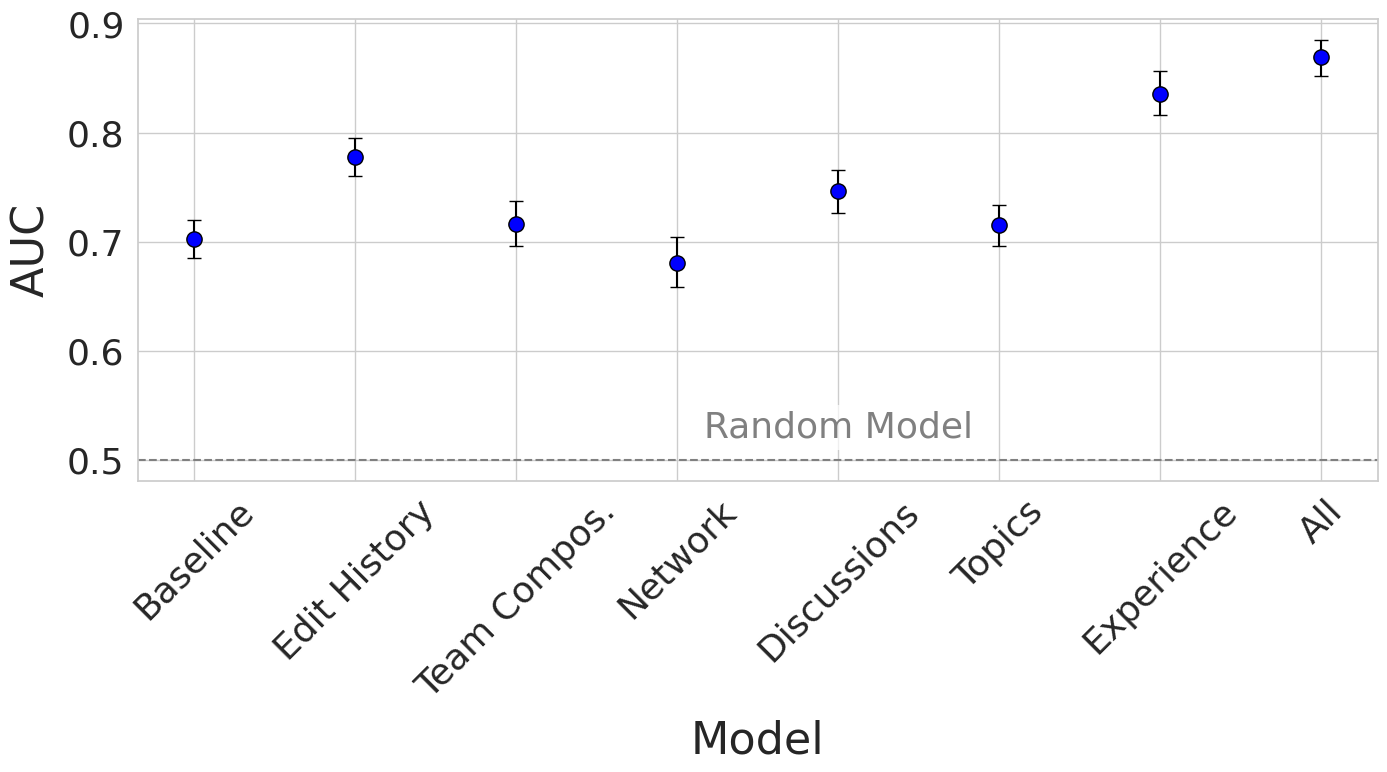

In [59]:
sns.set(style='whitegrid')
plt.figure(figsize=(16,6))

# NEW WAY - printing dots + error bars together
plt.errorbar(
    x=np.arange(len(concise_eval_measures_df)), 
    y=concise_eval_measures_df['mean'],
    yerr=[concise_eval_measures_df['lower_ci'], concise_eval_measures_df['upper_ci']],
    fmt='o',  # Marker style
    markersize=11,  # Size of markers
    markerfacecolor='blue',  # Fill color of markers
    markeredgecolor='black',  # Edge color of markers
    ecolor='black',  # Color of error bars
    capsize=5,  # Size of the error bar caps
    linestyle='none'  # No connecting lines
)
    
# Set x-axis labels to match the DataFrame index
plt.xticks(ticks=np.arange(len(concise_eval_measures_df)), labels=concise_eval_measures_df.index)

# add a horizontal line for random classifier
if columns_to_plot == 'macro_auc' or columns_to_plot == 'macro_f1_opt_th':
    horizontal_line_value = 0.5
elif columns_to_plot == 'binary_f1_optimal_th':
    horizontal_line_value = concise_eval_measures_df.iloc[0]['minority_class_perc']
else:
    raise IOError('Invalid columns_to_plot value. Try another one please.')

plt.axhline(y=horizontal_line_value, color='gray', linestyle='--', linewidth=1.5)

# Add text in the middle of the horizontal line
x_center = len(concise_eval_measures_df) / 2  # Center x-coordinate
plt.text(
    x=x_center, #+ 0.8, 
    y=horizontal_line_value+0.03,  # y-coordinate of the horizontal line
    s='Random Model',  # Text to display
    color='gray', 
    ha='center',  # Center align horizontally
    va='center',  # Center align vertically
    fontsize=26, 
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')  # Background for better readability
)

# adding all the x/y axis text
plt.xlabel("Model", fontsize=32, labelpad=10)
y_label_dict = {'macro_auc': 'AUC', 'macro_f1_opt_th': 'F1 (Macro)', 'binary_f1_optimal_th': 'F1 (Binary)'}
y_label_on_fig = y_label_dict[columns_to_plot]
plt.ylabel(y_label_on_fig, fontsize=32, labelpad=10)
plt.xticks(rotation=45, fontsize=26)
plt.yticks(fontsize=26) 

# Set y-ticks to every 0.1 (only if it causes problems)
#plt.yticks(np.arange(0.5, 1.0, 0.1), fontsize=26)  # Adjust y-tick values from 0 to 1 with a step of 0.1

# if required to save the fig
saving_file_name = usecase + '_models_perf_' + columns_to_plot + '.pdf'
if save_fig:
    plt.savefig(opj(base_folder, 'models', 'models_analysis', saving_file_name), format="pdf", bbox_inches="tight", dpi=1200)
plt.show()

# Option B - scatter plot, FA and GA together

### Data Loading

In [3]:
fa_models = list()
fa_results = list()
fa_models_to_import = ['10.01', '10.1', '10.11', '10.12', '10.13', '10.14', '10.15', '10.21']
fa_models_to_name_mapping = {'10.01': 'Baseline', '10.1': 'Edit History', '10.11': 'Team Compos.', '10.12': 'Network', '10.13': 'Discussions', '10.14': 'Topics', '10.15': 'Experience', '10.21': 'All'}

for cur_model in fa_models_to_import:
    cur_model_results_f_name = opj(model_folder, str(cur_model), 'bootstrap_eval_measures_test.csv')
    cur_results = pd.read_csv(cur_model_results_f_name)
    cur_results.set_index('Unnamed: 0', drop=True, inplace=True)
    list_of_performance = [float(i) for i in list(cur_results.iloc[0:100][columns_to_plot])]
    fa_models.extend([fa_models_to_name_mapping[cur_model]] * 100)
    fa_results.extend(list_of_performance)
# converting the dict I created into a DF
fa_data = {'model': fa_models, 'performance': fa_results, 'usecase': 'FA'}
fa_concise_eval_measures_df = pd.DataFrame(fa_data)

In [4]:
ga_models = list()
ga_results = list()
ga_models_to_import = ['20.01', '20.1', '20.11', '20.12', '20.13', '20.14', '20.15', '20.21']
ga_models_to_name_mapping = {'20.01': 'Baseline', '20.1': 'Edit History', '20.11': 'Team Compos.', '20.12': 'Network', '20.13': 'Discussions', '20.14': 'Topics', '20.15': 'Experience', '20.21': 'All'}
# this is based on the performance of the models
order_of_bars = ['Baseline', 'Network', 'Topics', 'Team Compos.', 'Discussions', 'Edit History', 'Experience', 'All']

for cur_model in ga_models_to_import:
    cur_model_results_f_name = opj(model_folder, str(cur_model), 'bootstrap_eval_measures_test.csv')
    cur_results = pd.read_csv(cur_model_results_f_name)
    cur_results.set_index('Unnamed: 0', drop=True, inplace=True)
    list_of_performance = [float(i) for i in list(cur_results.iloc[0:100][columns_to_plot])]
    ga_models.extend([ga_models_to_name_mapping[cur_model]] * 100)
    ga_results.extend(list_of_performance)
# converting the dict I created into a DF
ga_data = {'model': ga_models, 'performance': ga_results, 'usecase': 'GA'}
ga_concise_eval_measures_df = pd.DataFrame(ga_data)

In [5]:
concise_eval_measures_df = pd.concat([fa_concise_eval_measures_df, ga_concise_eval_measures_df], ignore_index=True, sort=False)

In [55]:
concise_eval_measures_df.groupby(['model', 'usecase'])['performance'].mean()[order_of_bars].values

array([0.6706254 , 0.70226659, 0.66229901, 0.68085389, 0.71609638,
       0.71469988, 0.73997763, 0.71637625, 0.75446906, 0.74605321,
       0.80008112, 0.77732977, 0.85060478, 0.83568968, 0.89493836,
       0.86887034])

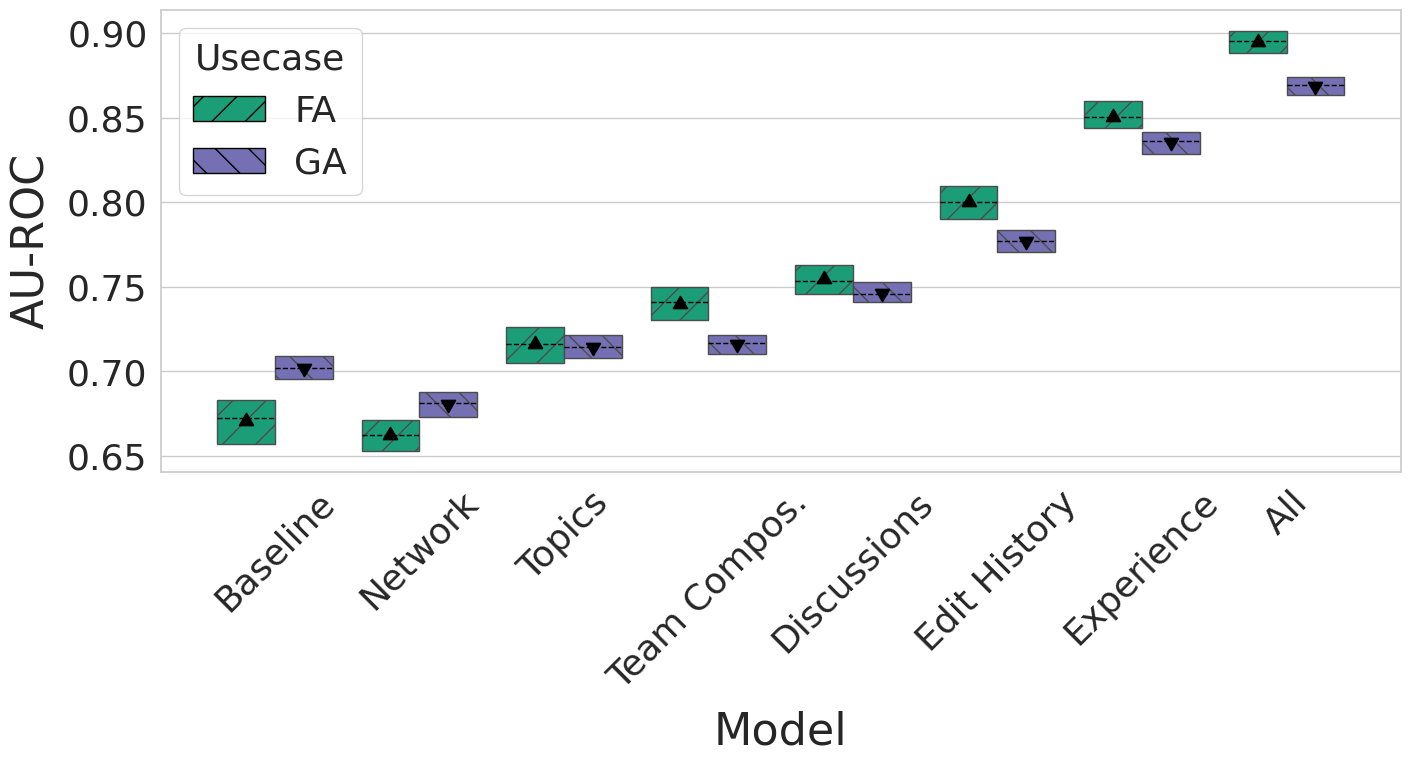

In [61]:
sns.set(style='whitegrid')
plt.figure(figsize=(16,6))

usecase_order = ['FA', 'GA']
# Create a boxplot using seaborn, setting the whiskers to the [5, 95] percentiles
ax = sns.boxplot(x='model', y='performance', data=concise_eval_measures_df, whis=0, showcaps=False, showfliers=False, order=order_of_bars, hue='usecase', hue_order=usecase_order, showmeans=False) #meanprops={"marker": "^", "markerfacecolor": "black", "markeredgecolor": "black", "markersize": "12"})

# in order to draw rectangles (up and down ones), I had to do the next trick... better to use simple meanprops with a single triangle type
averages = concise_eval_measures_df.groupby(['model', 'usecase'])['performance'].mean()[order_of_bars].values
ind = 0
for tick in range(len(ax.get_xticklabels())):
    plt.plot(tick-.2, averages[ind], marker=(3, 0, 0*90), markersize=12, linestyle='None', color='black')
    plt.plot(tick+.2, averages[ind+1], marker=(3, 0, 2*90), markersize=12, linestyle='None', color='black')
    #ax.text(tick+.2, m1[ind], 'a', horizontalalignment='center', color='r', weight='semibold')
    ind += 2 


# Define colors and patterns
colors = ['#1b9e77', '#7570b3']  # Custom hex colors for each box
patterns = ['/', '\\']  # Patterns for each box

# Create a dictionary to keep track of box counts for usecase
usecase_count = {'FA': 0, 'GA': 0}
    
# Apply colors and patterns to each box
for i, box in enumerate(ax.patches):
    # Set the color
    color_idx = 0 if i in range(0, 8) else 1
    box.set_facecolor(colors[color_idx])  # Cycle through colors
    box.set_facecolor(colors[color_idx])  # Cycle through colors

    # Add pattern
    # Create a pattern using a custom function
    pattern = patterns[color_idx]
    box.set_hatch(pattern)

# Adjust median line to be dashed
for line in ax.lines:
    # Check if the line is for the median (the 2nd line per box)
    if line.get_linestyle() == '-':
        line.set_linestyle('--')  # Make median line dashed
        line.set_color('black')  # Change median line color if desired

# adding all the x/y axis text
plt.xlabel("Model", fontsize=32, labelpad=10)
y_label_dict = {'macro_auc': 'AU-ROC', 'macro_f1_opt_th': 'F1 (Macro)', 'binary_f1_optimal_th': 'F1 (Binary)'}
y_label_on_fig = y_label_dict[columns_to_plot]
plt.ylabel(y_label_on_fig, fontsize=32, labelpad=10)
plt.xticks(rotation=45, fontsize=26)
plt.yticks(fontsize=26)

# Create custom legend with patches
legend_elements = [
    Patch(facecolor=colors[0], hatch=patterns[0], label='FA', edgecolor='black'),
    Patch(facecolor=colors[1], hatch=patterns[1], label='GA', edgecolor='black')
]

# Add the custom legend to the plot
plt.legend(handles=legend_elements, title='Usecase', fontsize=26, title_fontsize='26', loc='upper left', frameon=True)

# In case we want to add a random model horizontal line.
# add a horizontal line for random classifier
# if columns_to_plot == 'macro_auc' or columns_to_plot == 'macro_f1_opt_th':
#     horizontal_line_value = 0.5
# elif columns_to_plot == 'binary_f1_optimal_th':
#     # TODO: Fix here!!
#     horizontal_line_value = 0
# else:
#     raise IOError('Invalid columns_to_plot value. Try another one please.')
# plt.axhline(y=horizontal_line_value, color='gray', linestyle='--', linewidth=1.5)
# plt.yticks(np.arange(0.5, 1.0, 0.1), fontsize=26)  # Adjust y-tick values from 0 to 1 with a step of 0.1
# # Add text in the middle of the horizontal line
# x_center = (len(fa_models_to_name_mapping) / 2)-1  # Center x-coordinate
# plt.text(
#     x=x_center, #+ 0.8, 
#     y=horizontal_line_value+0.03,  # y-coordinate of the horizontal line
#     s='Random Model',  # Text to display
#     color='gray', 
#     ha='center',  # Center align horizontally
#     va='center',  # Center align vertically
#     fontsize=26, 
#     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')  # Background for better readability
# )
# Show the plot
saving_file_name = 'both_usecases_models_perf_' + columns_to_plot + '.pdf'
if save_fig:
    plt.savefig(opj(base_folder, 'models', 'models_analysis', saving_file_name), format="pdf", bbox_inches="tight", dpi=1200)
plt.show()